In [279]:
from ksvd import ksvd
import numpy as np
import scipy.io as scio
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
import skimage
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set()
from sklearn import metrics

In [280]:
def LoCo(Ux, Uy):
    USx, _, _ = np.linalg.svd(Ux, full_matrices=True)
    USy, _, _ = np.linalg.svd(Uy, full_matrice = True)
    return .5 * np.linalg.norm(Ux.T @ USy[:,1], ord = 2) + .5 * np.linalg.norm(Uy.T @ USx[:,1], ord = 2)

In [281]:
# Implementation of Gradient Descent function (Logistic Regresion, HW)
def GD(x0, gf, eta, fun=lambda x,itr: 0, niter=100, eps=1e-6):    
    '''
    Input: 
        x0: intilalization 
        gf: gradient function takes position argument 
        eta: step size
        obj: objective value takes position argument 
        niter: Number of iterations 
        
    Itermediate: 
        grad: Gradient    
        
    Output: 
        x: final solution 
        out: objective values per iterations 
    '''
    out = []
    x = x0.copy() 
    err = float('inf')
    itr = 0
    out.append(fun(x,itr))
    while (err>eps and itr<niter):
        grad = gf(x)
        x = x - eta*grad
        itr += 1
        out.append(fun(x,itr))
        err = np.abs(out[-1]-out[-2])/np.abs(out[-2])
    return x, itr, out

#Helper functions

# Define sigmoid function
def sigmoid_func(t):
    return 1. / (1 + np.exp(-t))


# Define derivative of sigmoid function
def sigmoid_func_derive(t):
    return np.exp(-t) / np.square(1 + np.exp(-t))


# Phi (defined in problem 3(a))
def phi(t):
    return np.log(1 + np.exp(-t))

def obj_func(xtr, ytr, lam, theta):
    obj_val = np.sum(phi(xtr.T.dot(theta) * ytr.T)) + lam * np.square(np.linalg.norm(theta))
    return obj_val

In [282]:
def FOTS(Ux, Uy):
    return np.linalg.norm(Ux - Uy, ord=frob)

In [283]:
# Soft Threshold function
def soft(z, lam):     
    return np.sign(z)*np.maximum(np.abs(z)-lam,0) 

In [284]:
# L21 proximal function (HW) 
def l21_prox(z, lam):
    """compute the proximal operator of L_21 norm with argument z and paramter lam"""
    x = z.copy()
    col_norm = np.linalg.norm(z,axis=0)
    idx = col_norm<=lam 
    idx_c = np.logical_not(idx)
    x[:,idx]=0
    x[:,idx_c]=(1-lam/col_norm[idx_c])*x[:,idx_c]
    return x

In [285]:
#ADMM Implementation of l2,1 norm-Robust PCA for summed datasets
def trioADMM_L21(L, SE, SH, E, H, lam, rho, niter=10): 
    '''
    Input: 
        L:     Shared Low Rank Component of the HR and EDA Sum Data Matrix 
        SE:    The Sparse Component of the EDA Data Matrix
        SH:    The Sparse Component of the HR Data Matrix
        E:     The EDA Data Matrix
        H:     The HR Data Matrix
        lam:   The regularization term 
        rho:   Augmented Lagrangian Parameter 
        niter: Number of Iterations 

    Intermediate: 
        W:     The scaled Dual variable 
        Z:     The summed matrix

    Output: 
        L:     The Shared Low Rank Component of the Data Matrix 
        SE:     The sparse component of the EDA data matrix (or can be thought of as EDA background noise)
        SH:     The sparse component of the HR data matrix (or can be thought of as HR background noise)
    '''
    Z = E + H
    W = Z-L-SE - SH
    for itr in range(niter):
        U,Sig,V = np.linalg.svd(Z-SE - SH +W, full_matrices=False)
        L = .5 * np.dot(np.dot(U,np.diag(soft(Sig,1/rho))),V)
        SE = l21_prox(Z - L - SH - W, lam/rho)
        SH = l21_prox(Z - L - SE - W, lam/rho)
        W = Z-L-SE - SH+W
    return L,SE, SH

In [286]:
train_split = .7

In [287]:
hr_df  = pd.read_csv('HR_FullTimeSeries.csv') # HR, EDA Data Extraction
hr_data = hr_df.drop(['Subject', 'FinalMS', '1350'], axis=1).to_numpy()
eda_df = pd.read_csv('EDA_FullTimeSeries.csv')
eda_data = eda_df.drop(['Subject', 'FinalMS', '1350'], axis=1).to_numpy()
ms_end_labels = hr_df['FinalMS'].to_numpy() # End True Labels for Logistic Regression
# Normalization
hr_data_normalized = np.divide(hr_data - np.mean(hr_data, axis=1, keepdims=True), np.std(hr_data, axis=1, keepdims=True))
eda_data_normalized = np.divide(eda_data - np.mean(eda_data, axis=1, keepdims=True), np.std(eda_data, axis=1, keepdims=True))

# MS Read in
ms_df = pd.read_csv('MS_DateTime_Complete_test.csv')
num_subjects = hr_data.shape[0]
num_train = int(num_subjects * train_split)
num_test = num_subjects - num_train
length = hr_data.shape[1]

hr_data = hr_data.T
eda_data = eda_data.T

hr_data_normalized = hr_data_normalized.T
eda_data_normalized = eda_data_normalized.T

In [288]:
i = 0
ms_interval_labels = np.ones((15, num_subjects)) * 2 # Labeing high as 2, anything not given presumed to be an early end, which corresponds to high
subject_names = hr_df['Subject'].unique() # so we only use subjects with phys data
grouped = ms_df.groupby(['Subject_Code'])

for subject in subject_names:
   
    subj_data =  grouped.get_group(subject)
    subj_ms_scores = subj_data['MSscore'].to_numpy()[1:]
    subj_ms_scores = np.where(subj_ms_scores <=3, 0, subj_ms_scores)
    subj_ms_scores = np.where((subj_ms_scores > 3) & (subj_ms_scores < 8), 1, subj_ms_scores)
    subj_ms_scores = np.where((subj_ms_scores >= 8 ) , 2, subj_ms_scores)
    
    if len(subj_ms_scores) < 15:
        subj_ms_scores = np.pad(subj_ms_scores, (0,15 - len(subj_ms_scores)), 'constant', constant_values = (2))
    if len(subj_ms_scores) > 15:
        subj_ms_scores = subj_ms_scores[:-1]
  
    ms_interval_labels[:, i] = subj_ms_scores
    
    i = i + 1
    #subj_data =  grouped.get_group(subject)
    #print(len(subj_data['MSscore'].to_numpy()))

In [289]:
#HR_train, HR_test, ms_train, ms_test = sklearn.model_selection.train_test_split(hr_data_normalized, ms_end_labels, test_size = num_test, random_state=2024)
#EDA_train, EDA_test, _, _ = sklearn.model_selection.train_test_split(eda_data_normalized, ms_end_labels, test_size = num_test, random_state=2024)

# Full Time Series Robust PCA

Rank of original data matrix is: 73
Rank of low rank data matrix is: 67
0.45454545454545453
0.026027730479202142


<Axes: title={'center': 'HR Noise'}>

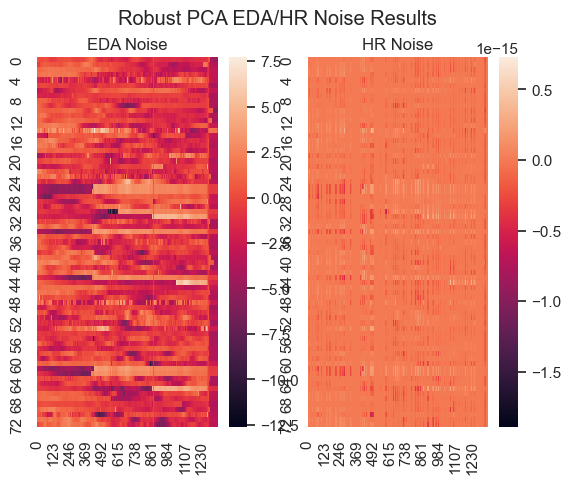

In [290]:
Rho = 1
k = 67
ld = 1/np.sqrt(length)
Z_init = (hr_data_normalized + eda_data_normalized).T
x_hat, noise_E, noise_H = trioADMM_L21(L=Z_init, SE = np.zeros(Z_init.shape), SH = np.zeros(Z_init.shape), E = eda_data_normalized.T, H = hr_data_normalized.T, lam=ld, rho=Rho)

#shared s_hat

print("Rank of original data matrix is: {}".format(np.linalg.matrix_rank(Z_init)))
print("Rank of low rank data matrix is: {}".format(k))

U,S,V = np.linalg.svd(x_hat.T, full_matrices=False)
x_rpca = np.dot(x_hat,U[:,:k]).T

num_train = int(num_subjects * train_split)
num_test = num_subjects - num_train
#x_tilde = np.concatenate([np.ones([1, num_subjects]), x_rpca], axis=0)

sum_train, sum_test, ms_sum_train, ms_sum_test = sklearn.model_selection.train_test_split(x_rpca.T, ms_end_labels, test_size = num_test, random_state=2024)
logRegr = LogisticRegression(penalty ='l1',solver='liblinear', max_iter=1000, warm_start=True)
logRegr.fit(sum_train, ms_sum_train)
score = logRegr.score(sum_test, ms_sum_test)
print(score)
predicted = logRegr.predict(sum_test)
rand = sklearn.metrics.adjusted_rand_score(ms_sum_test, predicted)
print(rand)

fig, axes = plt.subplots(1,2)
fig.suptitle("Robust PCA EDA/HR Noise Results")
axes[0].set_title('EDA Noise')
axes[1].set_title('HR Noise')
sns.heatmap(noise_E,ax = axes[0])
sns.heatmap(noise_H,ax = axes[1])


In [316]:
plt.savefig('PCA_rawdata.png')

<Figure size 640x480 with 0 Axes>

In [313]:
def triplePCA(Rho, k, HR_Data, EDA_Data,ms_labels,ld = 1/np.sqrt(length), printfigs = True):
    #Rho = 1
    #k = 67
    ld = 1/np.sqrt(length)
    Z_init = (HR_Data + EDA_Data).T
    x_hat, noise_E, noise_H = trioADMM_L21(L=Z_init, SE = np.zeros(Z_init.shape), SH = np.zeros(Z_init.shape), E = EDA_Data.T, H = HR_Data.T, lam=ld, rho=Rho)

    #shared s_hat
    if printfigs:
        print("Rank of original data matrix is: {}".format(np.linalg.matrix_rank(Z_init)))
        print("Rank of low rank data matrix is: {}".format(np.linalg.matrix_rank(x_hat)))
    x_rank = np.linalg.matrix_rank(x_hat)
   
    if x_rank < k:
        print('k set too high for out matrix of rank: ' + str(x_rank))
    k = min(x_rank,k)
    U,S,V = np.linalg.svd(x_hat.T, full_matrices=False)
    x_rpca = np.dot(x_hat,U[:,:k]).T

    num_train = int(num_subjects * train_split)
    num_test = num_subjects - num_train
    #x_tilde = np.concatenate([np.ones([1, num_subjects]), x_rpca], axis=0)

    sum_train, sum_test, ms_sum_train, ms_sum_test = sklearn.model_selection.train_test_split(x_rpca.T, ms_labels, test_size = num_test, random_state=2024)
    logRegr = LogisticRegression(penalty ='l1',solver='liblinear', max_iter=1000, warm_start=True)
    logRegr.fit(sum_train, ms_sum_train)
    score = logRegr.score(sum_test, ms_sum_test)
    #print(score)
    predicted = logRegr.predict(sum_test)
    rand = sklearn.metrics.adjusted_rand_score(ms_sum_test, predicted)
    #print(rand)
    if printfigs:
        fig, axes = plt.subplots(1,2)
        fig.suptitle("Robust PCA EDA/HR Noise Results")
        axes[0].set_title('EDA Noise')
        axes[1].set_title('HR Noise')
        sns.heatmap(noise_E,ax = axes[0])
        sns.heatmap(noise_H,ax = axes[1])
    
    return score, rand , x_rank


# 90 Block Windowing

In [293]:
blocks_raw_hr_train = np.squeeze(skimage.util.view_as_blocks(HR_train, block_shape = (num_train, 90)) )
blocks_raw_eda_train = np.squeeze(skimage.util.view_as_blocks(EDA_train, block_shape = (num_train, 90)) )

blocks_raw_hr_test = np.squeeze(skimage.util.view_as_blocks(HR_test, block_shape = (num_test, 90)) )
blocks_raw_eda_test = np.squeeze(skimage.util.view_as_blocks(EDA_test, block_shape = (num_test, 90)) )

In [294]:
blocks_raw_hr_full = np.squeeze(skimage.util.view_as_blocks(hr_data_normalized, block_shape = (90, num_subjects)))
blocks_raw_eda_full = np.squeeze(skimage.util.view_as_blocks(eda_data_normalized, block_shape = (90, num_subjects)))
print(blocks_raw_hr_full.shape)
print(ms_interval_labels.shape)

(15, 90, 73)
(15, 73)


Rank of original data matrix is: 73
Rank of low rank data matrix is: 37
Rank of original data matrix is: 73
Rank of low rank data matrix is: 42
Rank of original data matrix is: 73
Rank of low rank data matrix is: 40
Rank of original data matrix is: 73
Rank of low rank data matrix is: 44
Rank of original data matrix is: 73
Rank of low rank data matrix is: 46
Rank of original data matrix is: 68
Rank of low rank data matrix is: 48
Rank of original data matrix is: 68
Rank of low rank data matrix is: 47
Rank of original data matrix is: 67
Rank of low rank data matrix is: 48
Rank of original data matrix is: 67
Rank of low rank data matrix is: 44
Rank of original data matrix is: 67
Rank of low rank data matrix is: 46
Rank of original data matrix is: 65
Rank of low rank data matrix is: 47
Rank of original data matrix is: 65
Rank of low rank data matrix is: 47
Rank of original data matrix is: 64
Rank of low rank data matrix is: 45
Rank of original data matrix is: 64
Rank of low rank data matrix

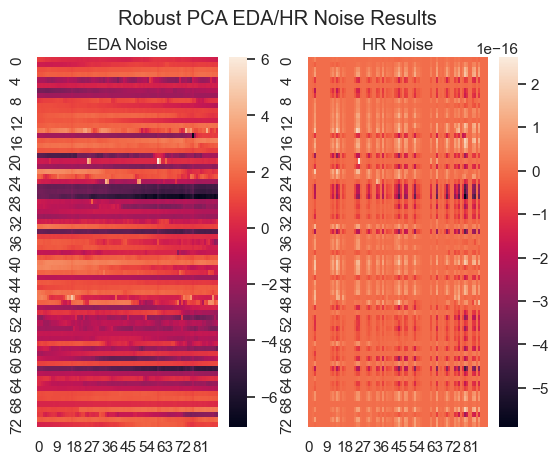

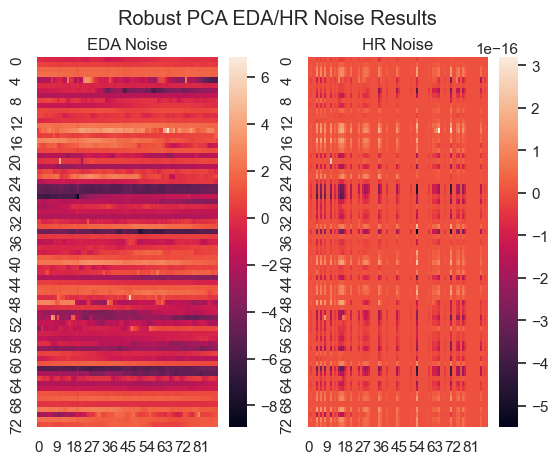

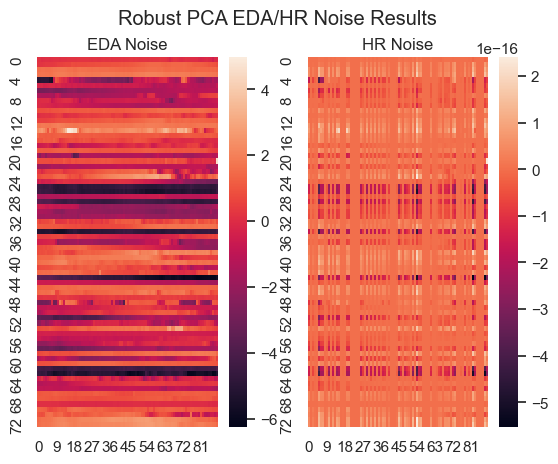

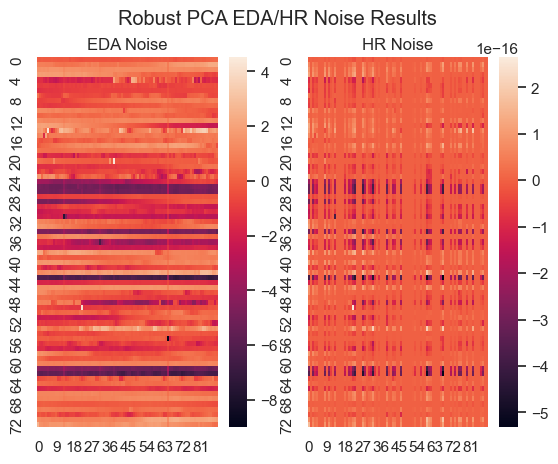

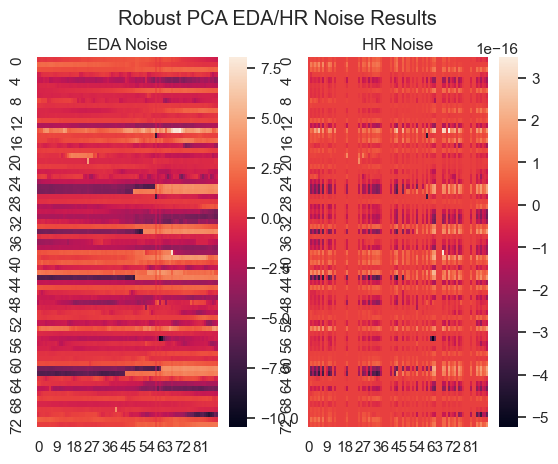

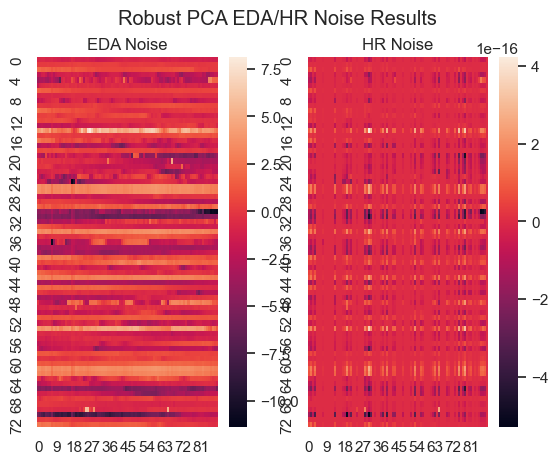

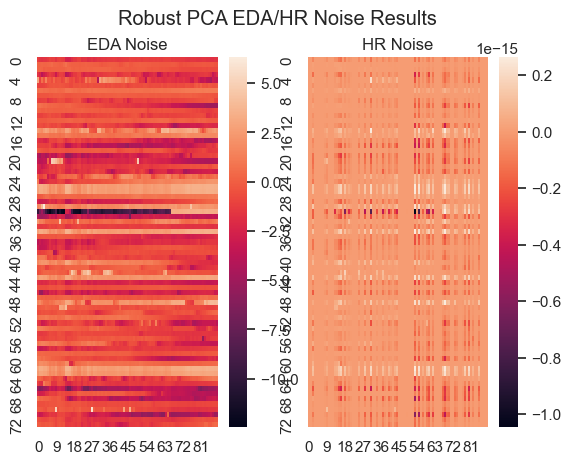

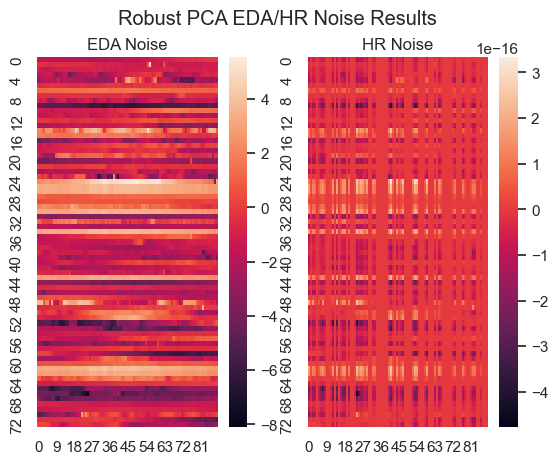

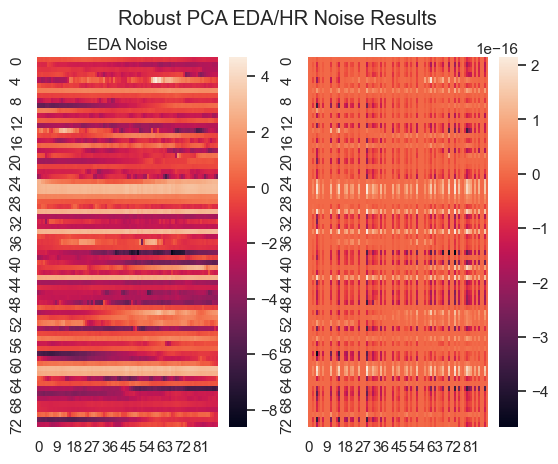

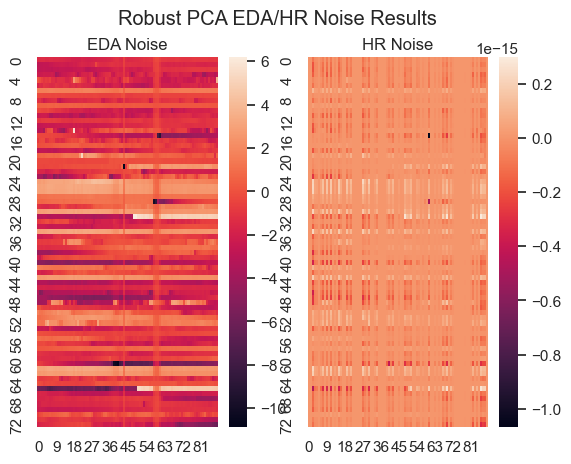

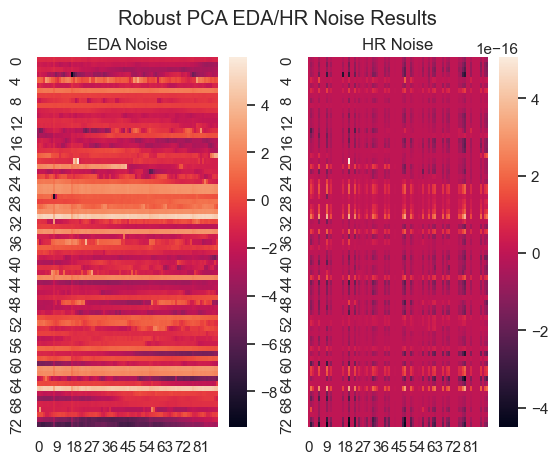

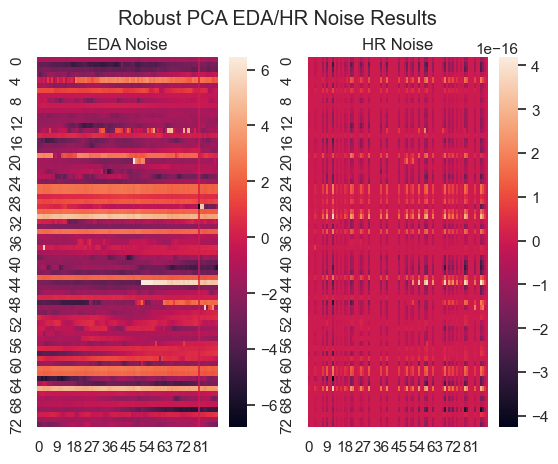

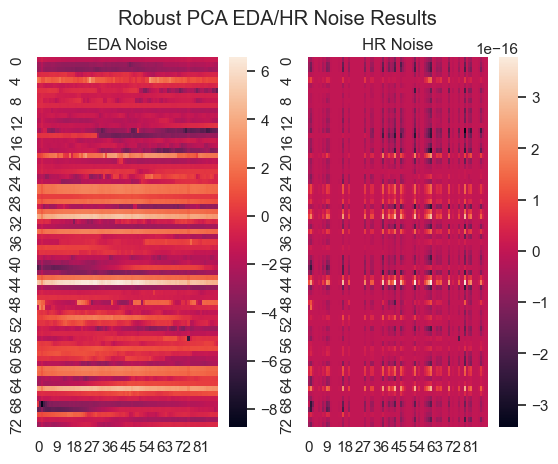

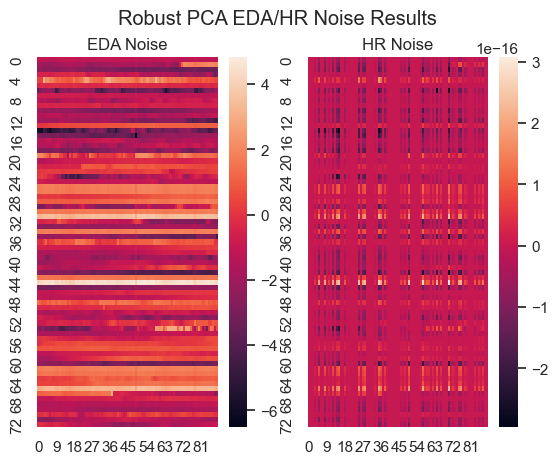

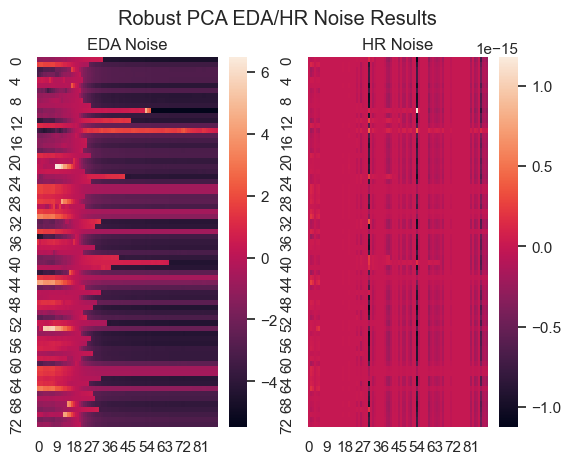

In [317]:
#k_sweep = np.array([3, 15, 25, 35])
#rho_sweep = np.array([.1, 1, 10])
k_sweep = np.array([3])
rho_sweep = np.array([1])
score_max = 0
rand_max = 0

k_max = np.array([3,3])
rho_max = np.array([.1,.1])
rank_avg = 0
for k in k_sweep:
    for Rho in rho_sweep:
        score_avg = 0
        rand_avg = 0
        rank_avg = 0
        for i in range(blocks_raw_hr_full.shape[0]):
            
            #Rho= 1
            #k = 20
            HR_Data = blocks_raw_hr_full[i,:,:]
            EDA_Data = blocks_raw_eda_full[i,:,:]
            ms_labels = ms_interval_labels[i,:]
            out_score, out_rand, out_rank = triplePCA(Rho, k, HR_Data, EDA_Data,ms_labels,ld = 1/np.sqrt(length),printfigs=True)
            score_avg = score_avg + out_score
            rand_avg = rand_avg + out_rand
            rank_avg = rank_avg + out_rank
            
        
        score_avg = score_avg / 15
        rand_avg = rand_avg / 15
        rank_avg = rank_avg / 15
        
        if score_avg > score_max:
            score_max = score_avg
            k_max[0] = k
            rho_max[0] = Rho
        if rand_avg > rand_max:
            rand_max = rand_avg
            k_max[1] = k
            rho_max[1] = Rho

print("Accuracy Max: " + str(score_max))
print("Rand Max: " + str(rand_max))
print("K Maxes: " + str(k_max[0]) + ", " + str(k_max[1]))
print("Rho Maxes: " + str(rho_max[0]) + ", " + str(rho_max[1]))
print("Average Rank: " + str(rank_avg))

## 

In [297]:
#HR_train, HR_test, ms_train, ms_test = sklearn.model_selection.train_test_split(blocks_raw_hr[0], ms_interval_labels[0,:], test_size = num_test, random_state=2024)

In [298]:
HR_train.shape

(51, 1350)

In [318]:
plt.savefig('PCA_rawnoise.png')

<Figure size 640x480 with 0 Axes>